## Defining the TDOFsystem function (as per exercise 1.2)

<img src="2DOF-F2_body.png" width="500">

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt



# The function TDOFsystem simulates a Two-DOF system

def T2DOFsystem(t, z, Tspan, u, SP):
    m1, c1, k1 = SP['m1'], SP['c1'], SP['k1']
    m2, c2, k2 = SP['m2'], SP['c2'], SP['k2']

    # Input forces
    u_interp = np.interp(t, Tspan, u)

    # State vector
    zdot = np.zeros(4)

    zdot[0] = z[2]  # x1dot
    zdot[1] = z[3]  # x2dot
    zdot[2] = (-c1 * z[2] - c2 * (z[2] - z[3]) - k1 * z[0] - k2 * (z[0] - z[1])) / m1  # x1dotdot
    zdot[3] = (-c2 * (z[3] - z[2]) - k2 * (z[1] - z[0]) + u_interp) / m2  # x2dotdot

    return zdot

### Forced system (random excited) <a class="anchor" id="3"></a>

##### System parameters, Initial conditions & Loading

In [2]:
# System parameters
SP = {
    'm1': 5, 'm2': 5,  # Mass
    'k1': 2500, 'k2': 2500,  # Stiffness
    'c1': 0.5, 'c2': 0.5  # Damping coefficient
}

# Initial conditions [x1 x2 x1dot x2dot] units [m, m, m/s, m/s]
IC = np.array([0, 0, 0, 0])
N = 4096                   # Equivalent to 2**12
fs = 20                    # sampling frequency
Tspan = np.arange(N) / fs  # Time vector


# Define the Random excitation

u = np.random.randn(N)    # Random excitation



##### Solving the model to obtain dynamic responses

In [3]:
# Solve ODE using odeint (Runge-Kutta scheme)
def system(z, t):
    return T2DOFsystem(t, z, Tspan, u, SP)

Zsim = odeint(system, IC, Tspan)

# Initialize Zsimdot
Zsimdot = np.zeros((N, 4))

# Calculate acceleration based on the simulated state vector
for t in range(N):
    t_current = Tspan[t]
    z_current = Zsim[t, :]
    u_current = u[t]
    Zsimdot[t, :] = T2DOFsystem(t_current, z_current, Tspan, u, SP)
    
    
    
# Re-naming zsims

d1 = Zsim[:, 0]   # Displacement at 1
d2 = Zsim[:, 1]   # Displacement at 2

v1 = Zsim[:, 2]   # Velocity at 1
v2 = Zsim[:, 3]   # Velocity at 2

a1 = Zsimdot[:, 2]  # Acceleration at 1
a2 = Zsimdot[:, 3]  # Acceleration at 2

#### Plotting the respones 

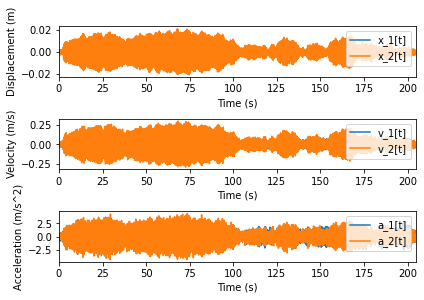

In [4]:
#### import matplotlib.pyplot as plt

# Plot simulated outputs
plt.figure(1)

# Plot displacement
plt.subplot(311)
plt.plot(Tspan, d1, label='x_1[t]')
plt.plot(Tspan, d2, label='x_2[t]')
plt.legend(loc='upper right')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')
plt.xlim([0,len(Tspan)/fs])

# Plot velocity
plt.subplot(312)
plt.plot(Tspan, v1, label='v_1[t]')
plt.plot(Tspan, v2, label='v_2[t]')
plt.legend(loc='upper right')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.xlim([0,len(Tspan)/fs])

# Plot acceleration
plt.subplot(313)
plt.plot(Tspan, a1, label='a_1[t]')
plt.plot(Tspan, a2, label='a_2[t]')
plt.legend(loc='upper right')
plt.ylabel('Acceleration (m/s^2)')
plt.xlabel('Time (s)')
plt.xlim([0,len(Tspan)/fs])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


#### Adding "artificial" noise before calculating PSD, CSD, H1, H2 and Coherence

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd

# Estimating the PSDs, CSDs and FRF - noise in the input and output
# Adding noise to the input and output signals

# Signal-Noise-Ratio (SNR) values
SNRin = 100  # Signal-to-Noise Ratio - Input (excitation) signal (SNR)
SNRout = 100  # Signal-to-Noise Ratio - Output (response) signal (SNR)


sigmaU1 = np.var(d1)                      # Variance of the response signal in Mass 1
sigmaU2 = np.var(d2)                      # Variance of the response signal in Mass 2
sigmaV1 = np.var(u)                       # Variance of the excitation signal (at location m2)        
sigmaN2 = sigmaU1 * 10 ** (-SNRout / 10)  # Variance of noise
sigmaM2 = sigmaV1 * 10 ** (-SNRin / 10)   # Variance of noise


# The Noisy outputs (at location m1)
y = d1 + np.sqrt(sigmaN2) * np.random.randn(1, N)
# The Noisy input (at location m2)
x = u + np.sqrt(sigmaM2) * np.random.randn(1, N)

# Parameters of the PSD/CPSD estimator

# Estimate excitation and response PSDs and CPSD
ff, Pyy = welch(y, fs, nperseg=1024)     # PSD of the response at the location m1
ff1, Pxx = welch(x, fs, nperseg=1024)    # PSD of the excitation at the location m2
ff2, Pyx = csd(y, x, fs, nperseg=1024)   # CSD between output (response at m1) and input (exciation at m2)

# Estimate FRF usinh H1 and H2 indicators 
H1 = Pyx / Pxx
H2 = Pyy / np.conj(Pyx)

# Calculate coherence
gamma2 = np.abs(Pyx)**2 / (Pxx * Pyy)


#### Plotting Time resposne and PSD using Welch estimator at m1 

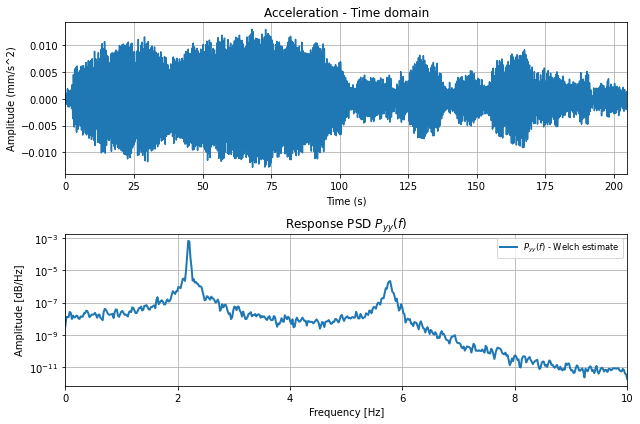

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the acceleration response signal at m1 in time domain
plt.figure(figsize=(9, 6))
plt.subplot(211)
plt.plot(Tspan, np.squeeze(y))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mm/s^2)')
plt.title('Acceleration - Time domain')
plt.xlim([0,len(Tspan)/fs])
plt.grid(True)

# Plotting the PSD of the acceleratiomn response signal's spectrum (Pyy)
plt.subplot(212)
plt.semilogy(ff, np.squeeze(Pyy), linewidth=2, label='$P_{yy}(f)$ - Welch estimate')
plt.title('Response PSD $P_{yy}(f)$')
plt.xlim([0, fs/2])
#plt.ylim([0, 50])
plt.legend(loc='best', fontsize='small', fancybox=True)
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB/Hz]')

# Show the plots
plt.tight_layout()
plt.show()




#### Plotting H1, H2 and Coherence at the response m1 with input in m2

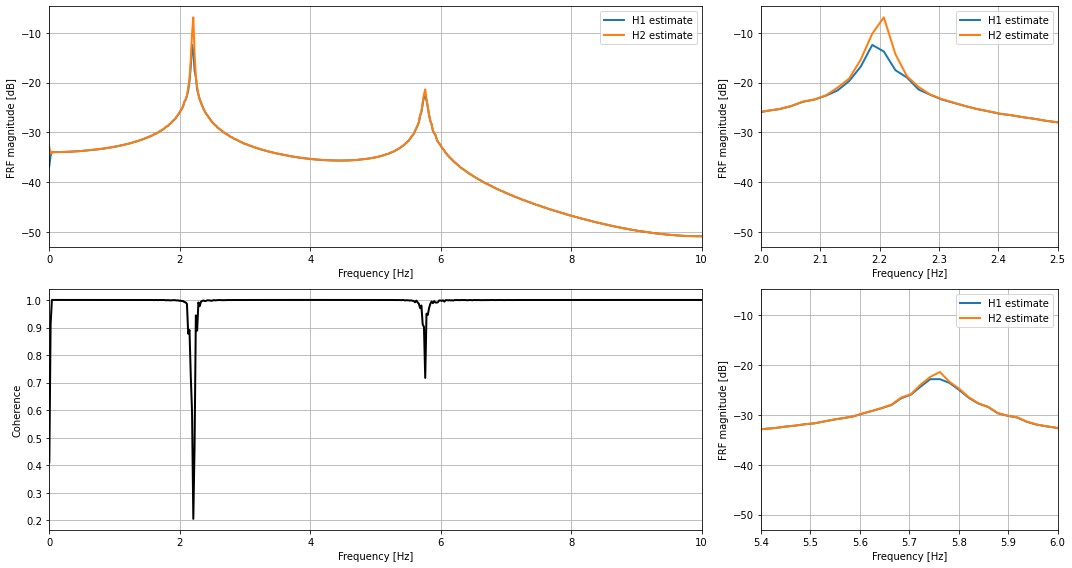

In [7]:
# Plotting H1 and H2 FRF estimators and the coherence function
plt.figure(figsize=(15, 8))

# Plotting H1 and H2 FRF estimators
plt.subplot(2, 3, (1,2))
plt.plot(ff1, np.squeeze(10 * np.log10(np.abs(H1))), linewidth=2, label='H1 estimate')
plt.plot(ff2, np.squeeze(10 * np.log10(np.abs(H2))), linewidth=2, label='H2 estimate')
plt.xlim([0, fs/2])
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
#plt.ylim([-80, -30])

# Plotting the coherence function
plt.subplot(2, 3, (4,5))
plt.plot(ff, np.squeeze(gamma2), linewidth=2, color='black')
plt.xlim([0, fs/2])
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')


# Plotting H1 and H2 FRF estimators ZOOM
plt.subplot(2, 3, (3))
plt.plot(ff1, np.squeeze(10 * np.log10(np.abs(H1))), linewidth=2, label='H1 estimate')
plt.plot(ff2, np.squeeze(10 * np.log10(np.abs(H2))), linewidth=2, label='H2 estimate')
plt.xlim([2, 2.5])
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
#plt.ylim([0.1, 20])

# Plotting H1 and H2 FRF estimators ZOOM
plt.subplot(2, 3, (6))
plt.plot(ff1, np.squeeze(10 * np.log10(np.abs(H1))), linewidth=2, label='H1 estimate')
plt.plot(ff2, np.squeeze(10 * np.log10(np.abs(H2))), linewidth=2, label='H2 estimate')
plt.xlim([5.4, 6])
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
#plt.ylim([0.1, 20])


# Show the plots
plt.tight_layout()
plt.show()




## Comparing with the theoretical FRF
Construct the matrices 

In [8]:
# FEM definition
n = 2                                     # Number of elements (How many measuring points or do

# Individual element stiffness and mass
                
Ko = 2500* np.array([[2, -1], [-1, 1]])   # k1=k2 The stiffness value per each beam-element
Co = 0.5* np.array([[2, -1], [-1, 1]])    # k1=k2 The stiffness value per each beam-element
Mo = 5*np.eye(2)                          # m1=m2 The mass of each element

print("Ko", Ko)
print("Mo", Mo)
print("Co", Co)


# Force input matrix
d = np.zeros(n)
d[1] = 1
print("d", d)

Ko [[ 5000 -2500]
 [-2500  2500]]
Mo [[5. 0.]
 [0. 5.]]
Co [[ 1.  -0.5]
 [-0.5  0.5]]
d [0. 1.]


Solving modal paramters

omegao [13.81966011 36.18033989]
Psi [[-0.2351141  -0.38042261]
 [-0.38042261  0.2351141 ]]
[0.00138197 0.00361803]


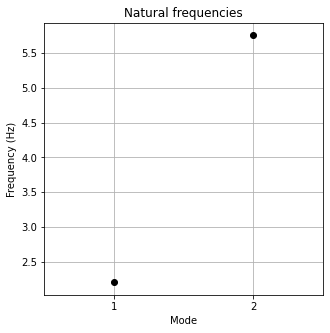

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la


# Perform modal analysis - undamped system
eigenvalues, eigenvectors = la.eigh(Ko, Mo)

# Extract natural frequencies (square root of eigenvalues)
omegaO = np.sqrt(eigenvalues.real)

print("omegao", omegaO)

# Psi contains the eigenvectors as columns
Psi = eigenvectors 

print("Psi", Psi)

# Modal damping
zeta = np.diag(Psi.T.dot(Co).dot(Psi)) / (2 * omegaO)  #zeta=(Phi^T*Co*Phi)/2*omegaO

print(zeta)

plt.figure(figsize=(5, 5))
plt.plot(np.arange(1, n + 1), omegaO / (2 * np.pi), 'o', color='black')
plt.grid(True)
plt.xlabel('Mode')
plt.ylabel('Frequency (Hz)')
plt.xlim(0.5, n + 0.5)
plt.xticks(np.arange(1, n + 1))
plt.title('Natural frequencies')
plt.show()


Computing FRFs

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve

# Define the frequency vector to calculate the FRF
nf = 513                                  # Number of frequency points for FRF calculation
fs= 20                                      # Sampling frequency
f = np.linspace(0, fs/2, nf)                # Generating the Frequency vector (Hz) 
Om = 2 * np.pi * f                          # Frequency vector (rad/s)

# Calculating the FRF

Ho = np.zeros((n, nf), dtype=complex)       # Buiding the matrix space

for i in range(nf):
    A = Ko - Mo * Om[i]**2 + 1j * Co * Om[i]
    Ho[:, i] = solve(A, d)                       # Solving a linear equation of this form a @ x == b


Ploting H1, H2 and FRF 

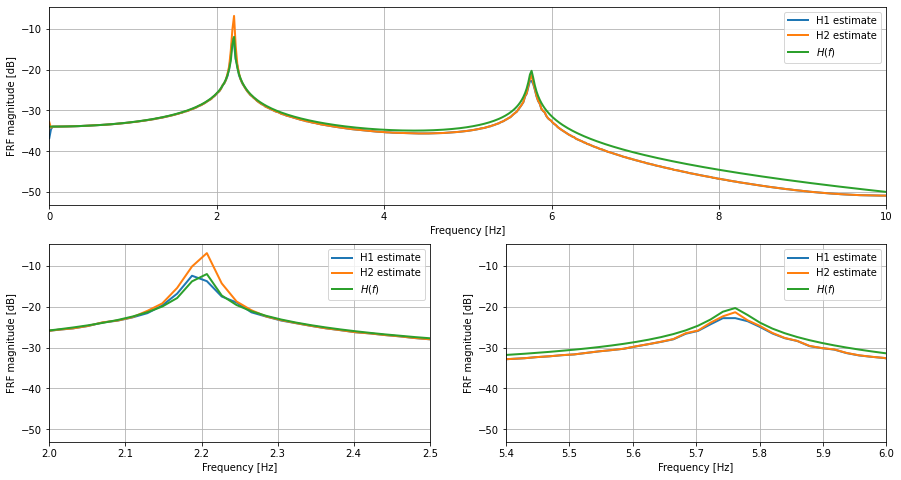

In [11]:
# Plotting H1 and H2 FRF estimators
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, (1,2))
plt.plot(ff1, np.squeeze(10 * np.log10(np.abs(H1))), linewidth=2, label='H1 estimate')
plt.plot(ff2, np.squeeze(10 * np.log10(np.abs(H2))), linewidth=2, label='H2 estimate')
#plt.plot(ff, np.squeeze(10 * np.log10(np.abs(Pyy))), linewidth=2, label='$P_{yy}(f)$ - Welch estimate')
plt.plot(f,  np.squeeze(10 * np.log10(np.abs(Ho[0, :]))), linewidth=2, label='$H(f)$')

plt.xlim([0, fs/2])
#plt.xlim([2, 3])
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
plt.grid(True)
#plt.ylim([-80, -30])

# Plotting H1 and H2 and FRF estimators ZOOM (peak 1)
plt.subplot(2, 2, (3))
plt.plot(ff1, np.squeeze(10 * np.log10(np.abs(H1))), linewidth=2, label='H1 estimate')
plt.plot(ff2, np.squeeze(10 * np.log10(np.abs(H2))), linewidth=2, label='H2 estimate')
plt.plot(f,  np.squeeze(10 * np.log10(np.abs(Ho[0, :]))), linewidth=2, label='$H(f)$')
plt.xlim([2, 2.5])
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
#plt.ylim([0.1, 20])

# Plotting H1 and H2 and FRF estimators ZOOM (peak 2)
plt.subplot(2, 2, (4))
plt.plot(ff1, np.squeeze(10 * np.log10(np.abs(H1))), linewidth=2, label='H1 estimate')
plt.plot(ff2, np.squeeze(10 * np.log10(np.abs(H2))), linewidth=2, label='H2 estimate')
plt.plot(f,  np.squeeze(10 * np.log10(np.abs(Ho[0, :]))), linewidth=2, label='$H(f)$')
plt.xlim([5.4, 6])
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
plt.grid(True)
#plt.ylim([0.1, 20])

As we know from theory $P_{yy}(f)=|H(f)|^2P_{xx}(f)$

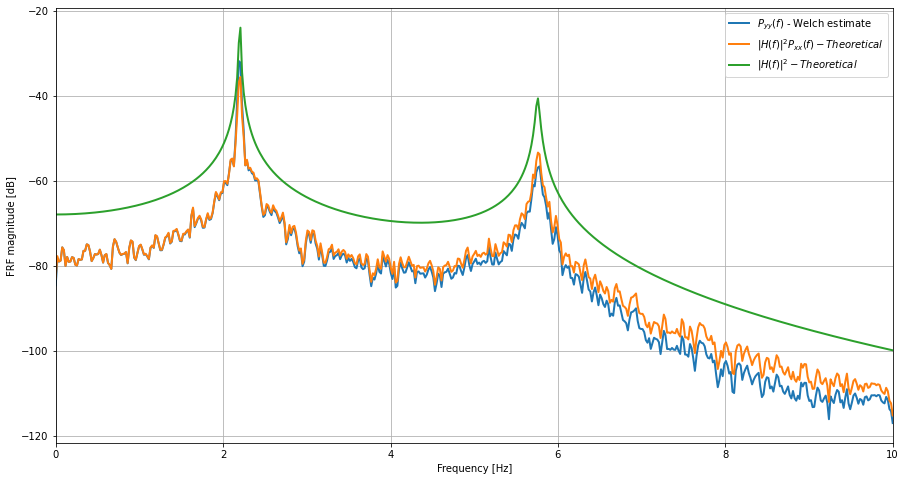

In [12]:
# Plotting H1 and H2 FRF estimators
plt.figure(figsize=(15, 8))
plt.plot(ff, np.squeeze(10 * np.log10(np.abs(Pyy))), linewidth=2, label='$P_{yy}(f)$ - Welch estimate')
plt.plot(f,  np.squeeze(10 * np.log10(np.abs(Ho[0, :]**2) * np.abs(Pxx))), linewidth=2, label='$|H(f)|^2P_{xx}(f) - Theoretical$')
plt.plot(f,  np.squeeze(10 * np.log10(np.abs(Ho[0, :]**2))), linewidth=2, label='$|H(f)|^2 - Theoretical$')
plt.xlim([0, fs/2])
#plt.xlim([2, 3])
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF magnitude [dB]')
plt.grid(True)